<a href="https://colab.research.google.com/github/podobongbong/the_project/blob/main/Nov18_2004.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/podobongbong/the_project.git
import os
os.chdir('/content/the_project')
import pandas as pd


fatal: destination path 'the_project' already exists and is not an empty directory.


In [2]:

# Energy Data (2004-2023)
energy_data = pd.read_csv('/content/the_project/data/energy.csv')
energy_data.columns = ['year','city','district','type','jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

#주택용
energy_data = energy_data[energy_data['type']=='주택용']
monthly_columns = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
aggregated_data = energy_data.groupby(['year','city'])[monthly_columns].sum().reset_index()

energy_data['city'] = energy_data['city'].replace({'서울특별시': 'seoul', '부산광역시': 'busan'})
aggregated_energy_data = energy_data.groupby(['year', 'city'])[monthly_columns].sum().reset_index()

energy_seoul = aggregated_energy_data[aggregated_energy_data['city'] == 'seoul']
energy_busan = aggregated_energy_data[aggregated_energy_data['city'] == 'busan']


In [3]:
# Population Data (2008-2024.9)
population_data = pd.read_csv('/content/the_project/data/population.csv')
population_data.columns = ['year', 'city', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
population_data = population_data[:-2]
population_data['city'] = population_data['city'].replace({'seoul': 'seoul', 'busan': 'busan'})


In [4]:

# Cliamte Data (2004-2023)
climate_busan = pd.read_csv('/content/the_project/data/climate_busan.csv')
climate_seoul = pd.read_csv('/content/the_project/data/climate_seoul.csv')
climate_data = pd.concat([climate_busan, climate_seoul], ignore_index=True)
df= climate_data.copy()

df['temp_range'] = df['high'] - df['low']
df['high_deviation'] = df['high'] - df['average']
df['low_deviation'] = df['average'] - df['low']
df = df.dropna()

## Climate feature selection: Primary Component Analysis
from sklearn.decomposition import PCA
import pandas as pd
climate_vars = df[['average', 'low', 'high', 'temp_range','high_deviation','low_deviation']]
climate_vars = climate_vars.dropna()

## Apply PCA to reduce to 1 or 2 components
pca = PCA(n_components=1)  # Adjust to 1 or 2 based on analysis
climate_pca = pca.fit_transform(climate_vars)
df['climate_summary'] = climate_pca[:, 0]  # Only the first component
df['city'] = df['station'].replace({108: 'seoul', 159: 'busan'})
df['city'] = df['city'].astype(str)

climate = df[['ym','city','climate_summary']]

In [5]:
urban_data = pd.read_csv('/content/the_project/data/urban_char.csv')
u_bcr_seoul = urban_data[urban_data['city']=='seoul']['bcr'].values.flatten().reshape(-1, 1)
u_bcr_busan = urban_data[urban_data['city']=='busan']['bcr'].values.flatten().reshape(-1, 1)
u_far_seoul = urban_data[urban_data['city']=='seoul']['far'].values.flatten().reshape(-1, 1)
u_far_busan = urban_data[urban_data['city']=='busan']['far'].values.flatten().reshape(-1, 1)

In [6]:

e_seoul = energy_seoul[monthly_columns].values.flatten().reshape(-1, 1)
e_busan = energy_busan[monthly_columns].values.flatten().reshape(-1, 1)

p_seoul = population_data[population_data['city'] == 'seoul'][monthly_columns].values.flatten().reshape(-1, 1)
p_busan = population_data[population_data['city'] == 'busan'][monthly_columns].values.flatten().reshape(-1, 1)



In [7]:
c_vars = ['ym','average', 'low', 'high', 'temp_range','high_deviation','low_deviation','climate_summary']
seoul = df[df['city']=='seoul'][c_vars]
busan = df[df['city']=='busan'][c_vars]

In [8]:
seoul['energy']=e_seoul
busan['energy']=e_busan

In [11]:
# imputate 2004-2007 (36 value) with mean value of population
import numpy as np

p_seoul_04 = np.repeat(np.mean(p_seoul), 48).reshape(-1, 1)
p_seoul_combined = np.concatenate((p_seoul_04, p_seoul), axis=0)

p_busan_04 = np.repeat(np.mean(p_busan), 48).reshape(-1, 1)
p_busan_combined = np.concatenate((p_busan_04, p_busan), axis=0)

u_bcr_seoul_04 = np.repeat(np.mean(u_bcr_seoul), 126).reshape(-1, 1)
u_bcr_seoul_combined = np.concatenate((u_bcr_seoul_04, u_bcr_seoul), axis=0)

u_far_seoul_04 = np.repeat(np.mean(u_far_seoul), 126).reshape(-1, 1)
u_far_seoul_combined = np.concatenate((u_far_seoul_04, u_far_seoul), axis=0)

u_far_busan_04 = np.repeat(np.mean(u_far_busan), 126).reshape(-1, 1)
u_far_busan_combined = np.concatenate((u_far_busan_04, u_far_busan), axis=0)

u_bcr_busan_04 = np.repeat(np.mean(u_bcr_busan), 126).reshape(-1, 1)
u_bcr_busan_combined = np.concatenate((u_bcr_busan_04, u_bcr_busan), axis=0)


In [12]:
seoul_04 = seoul.iloc[0:240].reset_index(drop=True)
busan_04 = busan.iloc[0:240].reset_index(drop=True)
seoul_04['pop'] = p_seoul_combined
busan_04['pop'] = p_busan_combined
seoul_04['urban_bcr'] = u_bcr_seoul_combined
seoul_04['urban_far'] = u_far_seoul_combined
busan_04['urban_bcr'] = u_bcr_busan_combined
busan_04['urban_far'] = u_far_busan_combined

In [16]:
seoul_04.to_csv('/content/the_project/seoul_04.csv', index=False)
busan_04.to_csv('/content/the_project/busan_04.csv', index=False)

          average         low        high  temp_range  high_deviation  \
count  240.000000  240.000000  240.000000  240.000000      240.000000   
mean    13.020417    9.111250   17.628333    8.517083        4.607917   
std     10.058534   10.193554   10.062326    1.385792        0.740392   
min     -7.200000  -10.500000   -3.400000    4.900000        2.800000   
25%      3.900000    0.050000    8.250000    7.600000        4.100000   
50%     14.200000    9.550000   19.500000    8.500000        4.600000   
75%     22.425000   18.625000   27.125000    9.500000        5.100000   
max     28.800000   25.200000   33.300000   12.000000        6.400000   

       low_deviation  climate_summary        energy           pop   urban_bcr  \
count     240.000000       240.000000  2.400000e+02  2.400000e+02  240.000000   
mean        3.909167        -1.927870  1.118079e+09  9.947779e+06   54.352588   
std         0.669478        17.460842  1.467215e+08  2.541776e+05    0.030723   
min         2.1000

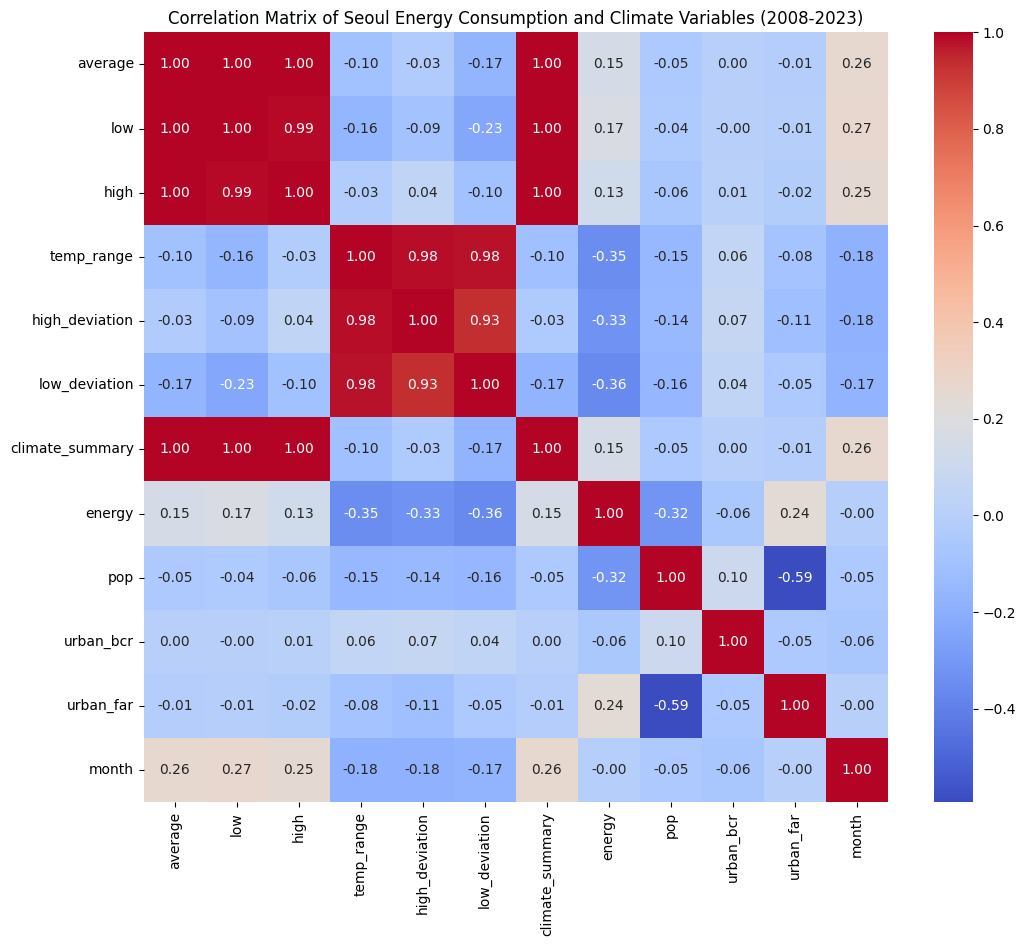

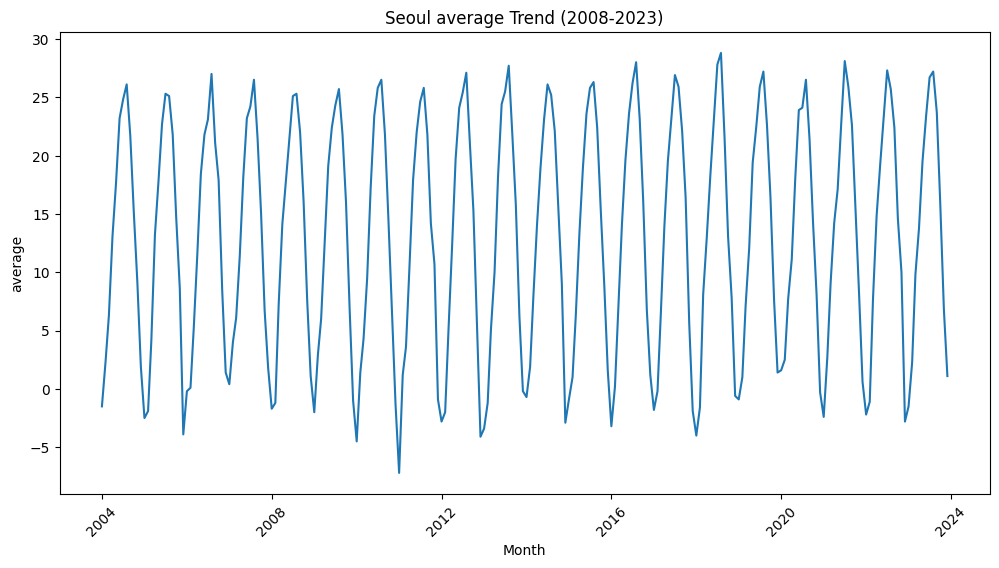

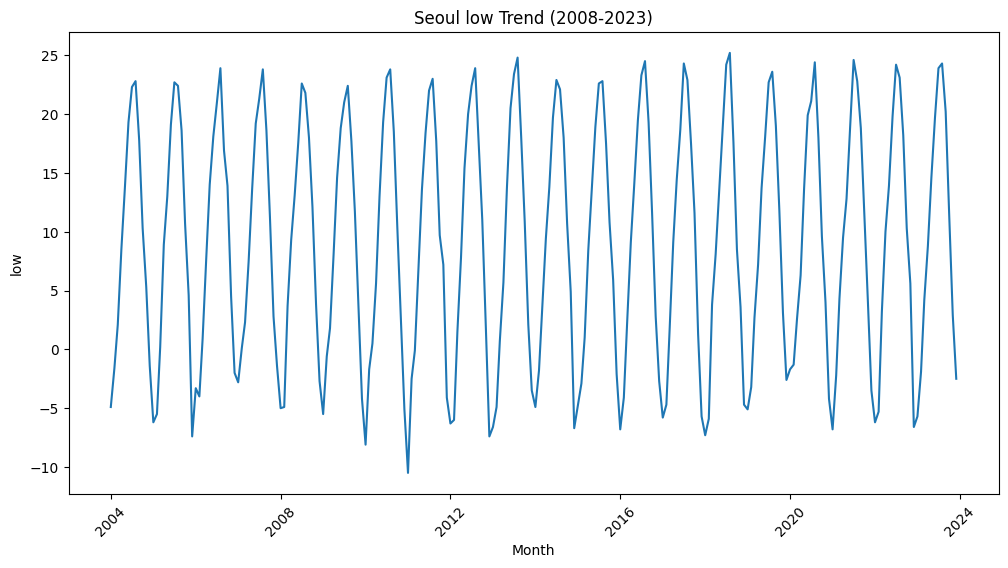

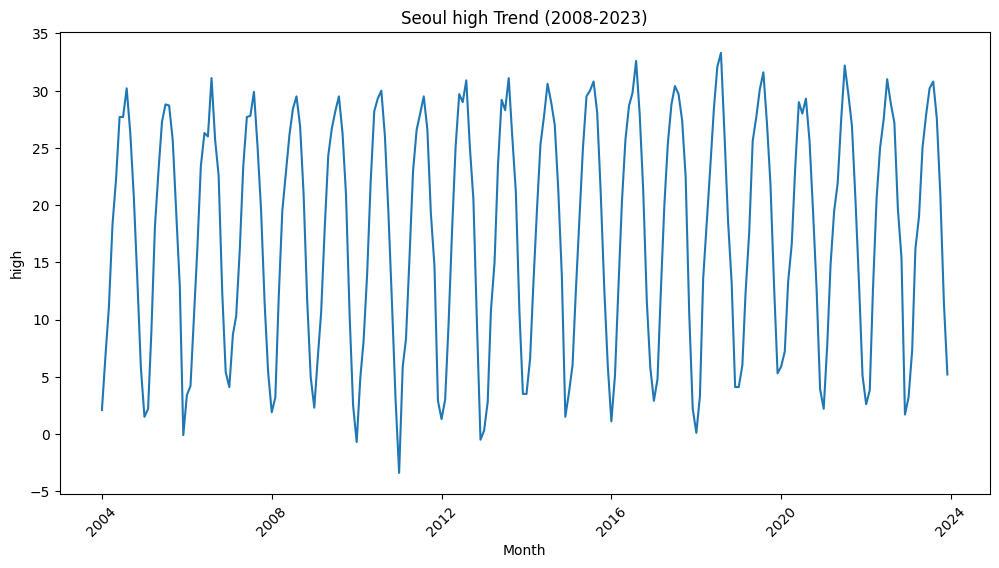

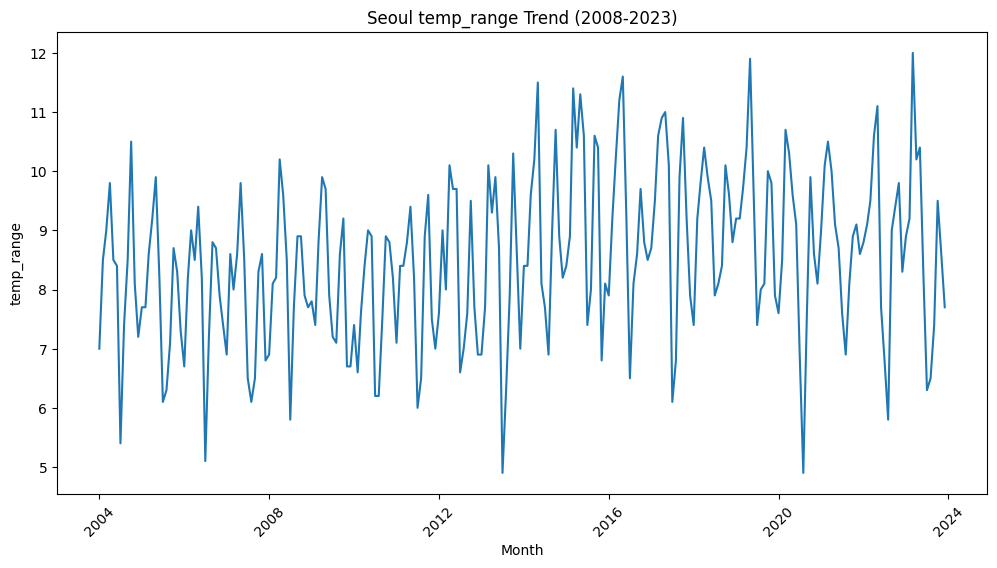

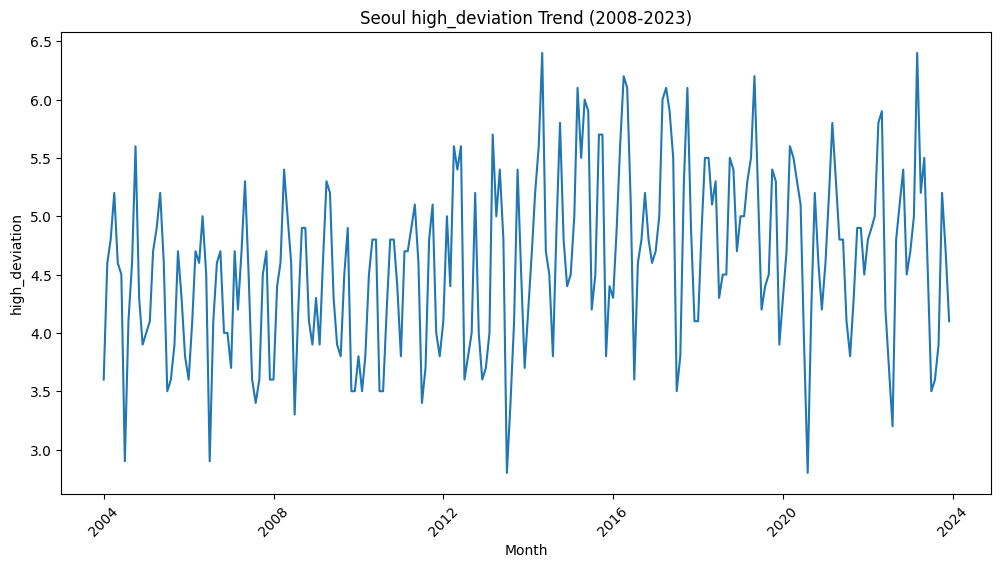

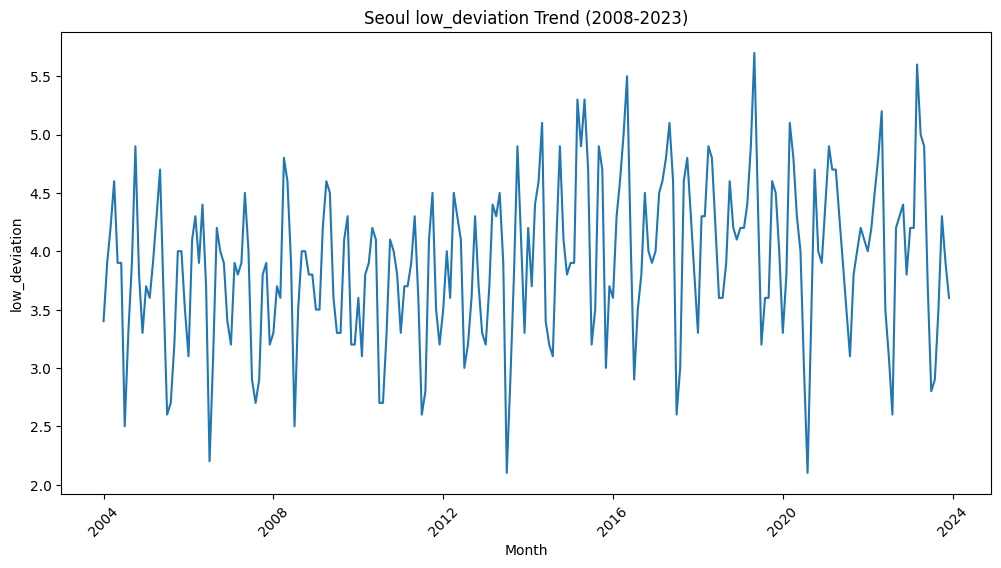

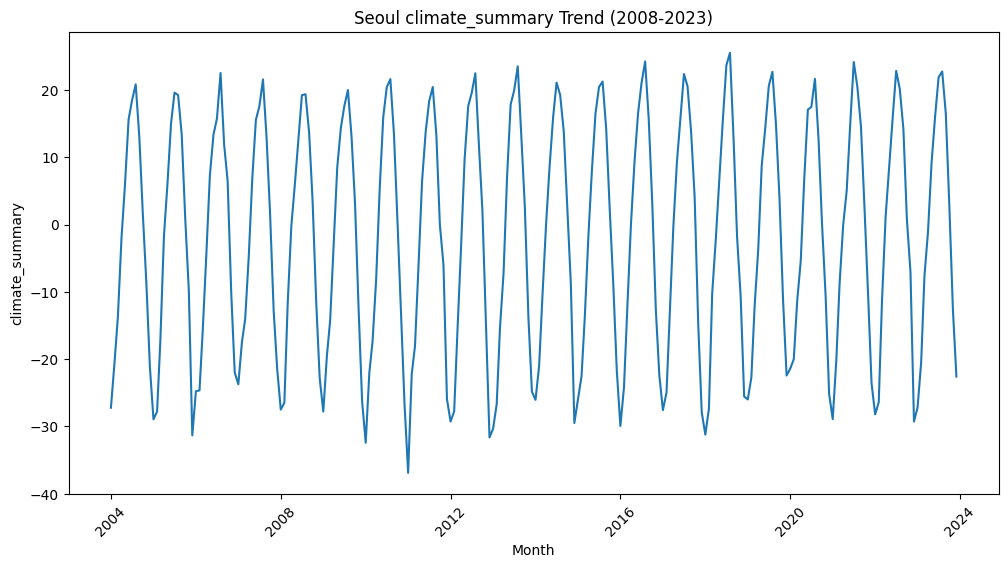

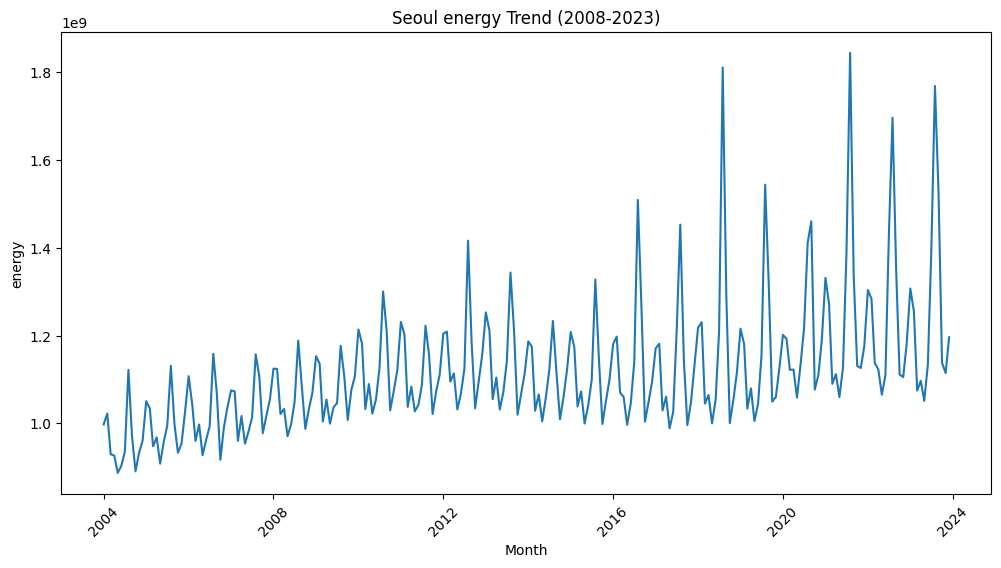

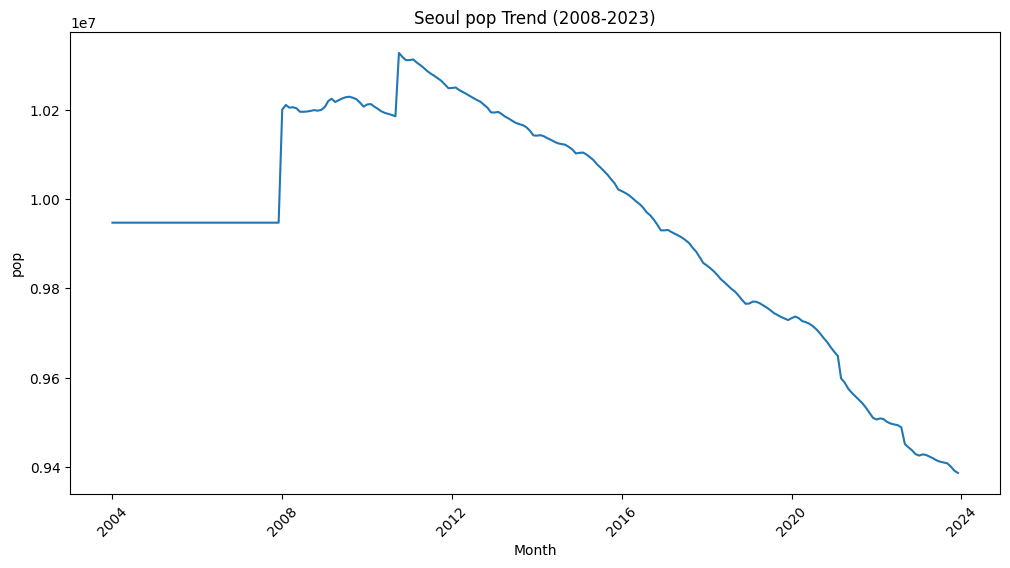

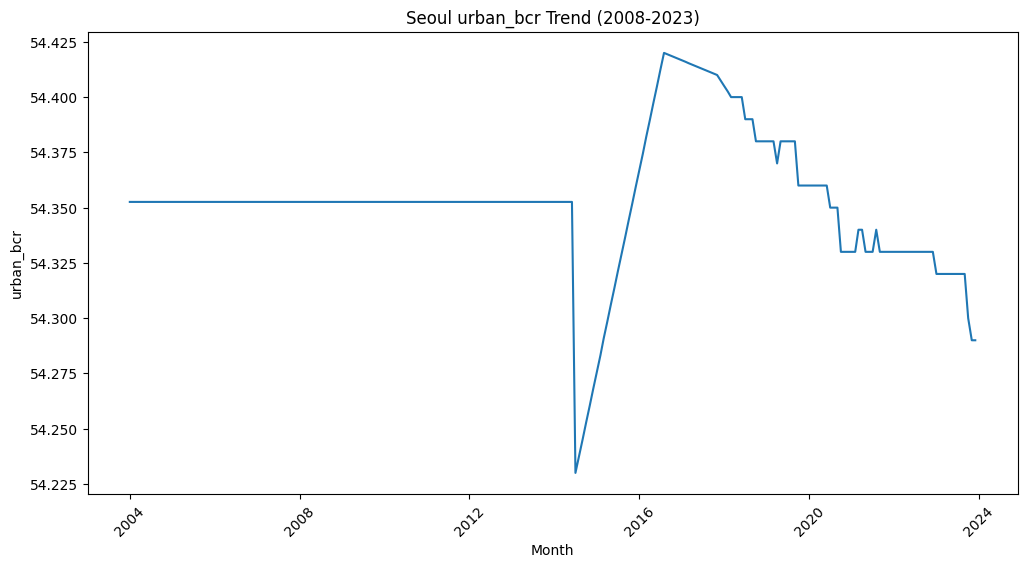

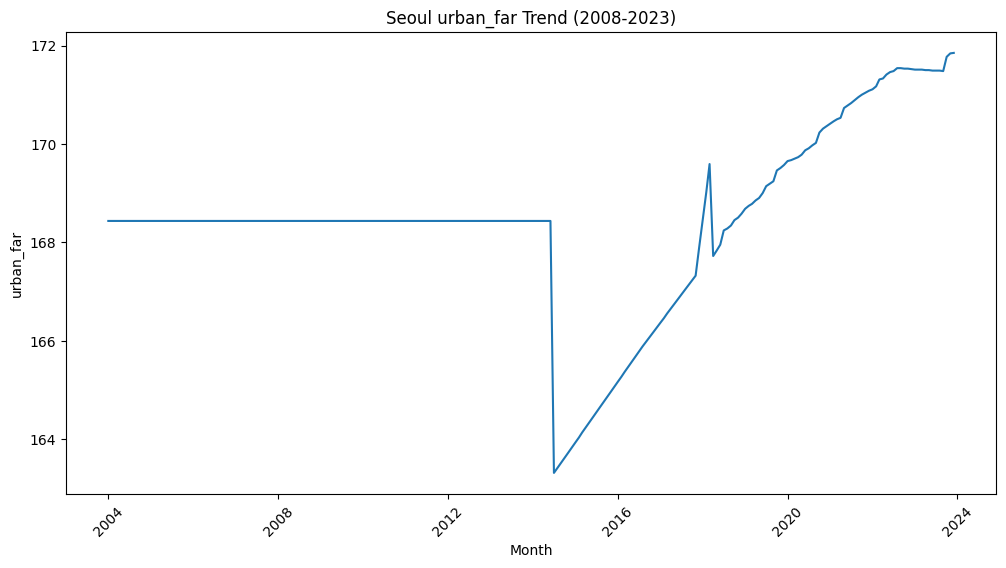

In [18]:
###null

# prompt: seoul_04 exploratory data analysis


# Descriptive Statistics
print(seoul_04.describe())

import matplotlib.pyplot as plt
import seaborn as sns
# Convert the 'ym' column to datetime objects
seoul_04['ym'] = pd.to_datetime(seoul_04['ym'].str.strip(), format='%Y-%m')

# Extract the month as a numerical feature for correlation analysis
seoul_04['month'] = seoul_04['ym'].dt.month

# Correlation Matrix (excluding the original 'ym' column)
correlation_matrix = seoul_04.drop(columns=['ym']).corr()  # Exclude 'ym'
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Seoul Energy Consumption and Climate Variables (2008-2023)')
plt.show()

# Time Series Plots for all variables in seoul_04
for column in seoul_04.columns:
  if column not in ['ym', 'month']:  # Exclude 'ym' and 'month' columns
    plt.figure(figsize=(12, 6))
    plt.plot(seoul_04['ym'], seoul_04[column])
    plt.xlabel('Month')
    plt.ylabel(column)
    plt.title(f'Seoul {column} Trend (2008-2023)')
    plt.xticks(rotation=45)
    plt.show()


In [ ]:
# prompt: busan_08 exploratory data analysis

# Descriptive Statistics
print(busan_08.describe())

import matplotlib.pyplot as plt
import seaborn as sns
# Convert the 'ym' column to datetime objects
busan_08['ym'] = pd.to_datetime(busan_08['ym'].str.strip(), format='%Y-%m')

# Extract the month as a numerical feature for correlation analysis
busan_08['month'] = busan_08['ym'].dt.month

# Correlation Matrix (excluding the original 'ym' column)
correlation_matrix = busan_08.drop(columns=['ym']).corr()  # Exclude 'ym'
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Busan Energy Consumption and Climate Variables (2008-2023)')
plt.show()



# Time Series Plots for all variables in busan_08
for column in busan_08.columns:
  if column not in ['ym', 'month']:  # Exclude 'ym' and 'month' columns
    plt.figure(figsize=(12, 6))
    plt.plot(busan_08['ym'], busan_08[column])
    plt.xlabel('Month')
    plt.ylabel(column)
    plt.title(f'Busan {column} Trend (2008-2023)')
    plt.xticks(rotation=45)
    plt.show()



In [ ]:
#부산, 서울 모두 2010년 10월 인구 통계가 뜀: 거주불명자(2010년 10월부터 통계포함)로 인한 것으로 보임. 거주불명자 인구 따로 제공 되지 않음